In [1]:
import time

import cv2
import torch
import torch.nn as nn
from torchvision.io import read_image
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, ToTensor

from yolort.utils import Visualizer

In [2]:
# configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
use_cuda = False if str(device) == "cpu" else True

weights_bcls = "/home/ajvalenc/OneDrive - University of Ottawa/Projects/spectronix/thermal/Cpp_Codes/weights/traced_bcls-{}.pt".format(device).replace(":0","")
weights_bdet = "/home/ajvalenc/OneDrive - University of Ottawa/Projects/spectronix/thermal/Cpp_Codes/weights/traced_bdet-{}.pt".format(device).replace(":0","")
weights_fdet = "/home/ajvalenc/OneDrive - University of Ottawa/Projects/spectronix/thermal/Cpp_Codes/weights/traced_fdet-{}.pt".format(device).replace(":0","")

In [3]:
# load torchscript models 
print("Loading binary model...")
model_bcls = torch.jit.load(weights_bcls)
print("Binary model loaded successfully")

print("Loading detection model...")
model_bdet = torch.jit.load(weights_bdet)
print("Detection model loaded successfully")

print("Loading detection model...")
model_fdet = torch.jit.load(weights_fdet)
print("Detection model loaded successfully")

Loading binary model...
Binary model loaded successfully
Loading detection model...
Detection model loaded successfully
Loading detection model...
Detection model loaded successfully


In [4]:
# input data and transform (using opencv)
filename = "/home/ajvalenc/Datasets/spectronix/thermal/BinClass_Test/Pos/T_IM_45.png"
img = cv2.imread(filename) #input

img = torch.as_tensor(img.astype("float32").transpose(2,0,1)).to(device)
img /= 255.
img = img.unsqueeze(0)

In [5]:
# dry run
for i in range(5):
    model_bcls(img)
    model_bdet(img)
    model_fdet(img)

/home/ajvalenc/.local/lib/python3.8/site-packages/torch/nn/modules/module.py:1130: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return forward_call(*input, **kwargs)
code/__torch__/yolort/models/yolo.py:42: UserWarning: YOLO always returns a (Losses, Detections) tuple in scripting.
code/__torch__/yolort/models/yolo/___torch_mangle_647.py:42: UserWarning: YOLO always returns a (Losses, Detections) tuple in scripting.


In [10]:
with torch.no_grad(): #ensures autograd is off
    start = time.time()
    out_bcls = model_bcls(img)
    end = time.time()
    print("Blood classification runtime [ms]: ", 1000*(end-start))

    start = time.time()
    out_bdet = model_bdet(img)
    end = time.time()
    print("Blood detection runtime [ms]: ", 1000*(end-start))

    start = time.time()
    out_fdet = model_fdet(img)
    end = time.time()
    print("Face detection runtime [ms]: ", 1000*(end-start))

Blood classification runtime [ms]:  1015.599250793457
Blood detection runtime [ms]:  159.94763374328613
Face detection runtime [ms]:  158.6899757385254


In [13]:
print("Output bdet:", out_bdet[1][0])
print("Output fdet:", out_fdet[1][0])

Output bdet: {'scores': tensor([0.54667, 0.54289, 0.43520]), 'labels': tensor([0, 0, 1]), 'boxes': tensor([[305.09998, 256.44388, 390.91913, 334.18600],
        [253.71140, 282.03439, 272.27829, 303.39835],
        [204.28300, 307.78754, 214.77779, 320.97644]])}
Output fdet: {'scores': tensor([0.85518, 0.65909]), 'labels': tensor([0, 1]), 'boxes': tensor([[131.80284,  59.93649, 180.86443, 117.50941],
        [155.98619,  71.70175, 172.69487,  79.96494]])}


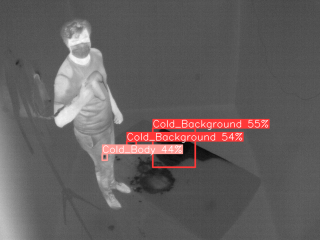

In [15]:
# verify results
img_raw = cv2.imread(filename) #original
v = Visualizer(img_raw, ["Cold_Background", "Cold_Body", "Warm_Background", "Warm_Body", "Warm_Dripping"])
v.draw_instance_predictions(out_bdet[1][0])
v.imshow(scale=0.5)

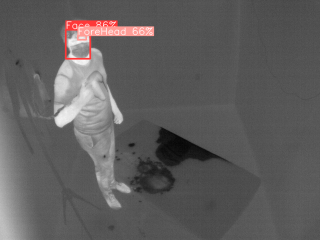

In [14]:
# verify results
img_raw = cv2.imread(filename) #original
v = Visualizer(img_raw, ["Face", "ForeHead"])
v.draw_instance_predictions(out_fdet[1][0])
v.imshow(scale=0.5)